# Homework 6: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

We have provided training and testing datasets for you to use, that way you're not going to introduce the problem of random sampling when you test your models.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points).

3. Tune your Random Forest model by varying hyperparamters (15 points).

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points).

4. Report the most important feature(s) based on your Random Forest classifier (10 points).

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os

In [449]:
# read the data set first
malicious = pd.read_csv('data/malicious_and_benign.csv')
malicious_test = pd.read_csv('data/malicious_and_benign_test.csv')
malicious.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [450]:
malicious_train = pd.concat([malicious, malicious_test]).drop_duplicates(keep=False)
malicious_train.shape[0]

1424

In [451]:
# data cleaning preprocess
# delete 'URL', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'
malicious_train_New = malicious_train.drop(['URL', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis=1)
malicious_test_New = malicious_test.drop(['URL', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis=1)
malicious_train_New.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,16,7,iso-8859-1,nginx,263.0,None,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,17,6,ISO-8859-1,nginx,162.0,US,AK,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,17,6,UTF-8,None,124140.0,US,TX,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [452]:
# count number of na values in the data set
malicious_train_New.shape[0] - malicious_train_New.count()

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               645
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [453]:
malicious_train_New = malicious_train_New.drop(['CONTENT_LENGTH'], axis=1)
malicious_test_New = malicious_test_New.drop(['CONTENT_LENGTH'], axis=1)

In [454]:
malicious_train_New = malicious_train_New.replace('None', np.nan)
malicious_test_New = malicious_test_New.replace('None', np.nan)
malicious_train_New.shape[0] - malicious_train_New.count()

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        6
SERVER                       137
WHOIS_COUNTRY                246
WHOIS_STATEPRO               298
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [455]:
malicious_train_New = malicious_train_New.dropna()
malicious_test_New = malicious_test_New.dropna()
print('Number of lines in cleaned training data set: ', malicious_train_New.shape[0])
print('Number of lines in cleaned test data set: ', malicious_test_New.shape[0])

Number of lines in cleaned training data set:  1002
Number of lines in cleaned test data set:  258


In [456]:
# create transfer dic for every unique choice in specific column
def createUniqueKey(frame, name):
    list_ = frame[name].unique().tolist()
    dic_ = {}
    item_number = 0
    for item in list_:
        dic_[item] = item_number
        item_number += 1
    return dic_
def turnAllIntoDummy(dtFrame, name_):
    dic = createUniqueKey(dtFrame, name_)
    dtFrame[name_] = dtFrame[name_].replace(dic)
    return dtFrame

In [457]:
Dummy_list = ["CHARSET", "WHOIS_COUNTRY", "WHOIS_STATEPRO", "SERVER"]
for name in Dummy_list:
    malicious_train_New = turnIntoDummy(malicious_train_New, name)
    malicious_test_New = turnIntoDummy(malicious_test_New, name)
malicious_train_New.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
3,17,6,0,0,0,0,31,22,3,3812,39,37,18784,4380,39,8.0,0
5,18,7,1,0,1,1,11,6,9,894,11,13,838,894,11,0.0,0
16,21,7,2,0,2,2,6,0,2,603,8,9,1580,745,8,2.0,1
19,22,7,3,1,0,3,9,0,4,850,11,9,1354,994,11,2.0,1
20,22,6,4,2,0,4,39,29,6,3833,43,42,22495,4125,43,4.0,0


In [458]:
malicious_test_New.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,78,15,0,0,0,0,8,6,6,672,8,9,562,672,8,0.0,0
1,39,8,1,1,0,1,0,0,0,0,0,0,0,0,0,0.0,0
2,43,9,1,0,0,1,83,2,3,6008,87,107,147266,6312,87,4.0,0
3,52,10,0,2,1,2,0,0,0,0,0,0,0,0,0,0.0,0
4,100,20,2,2,2,3,1,0,1,66,1,3,190,66,1,0.0,1


#### Comment for data cleaning preprocess:
* After checking the data set, we found that there are too many nan values in column 'CONTENT_LENGTH'. Also, this content_length variable seems to be distinct in each piece of information, which means that it may not make any contribution to the classification result.Thus we ignore this column directly in this data set. Also, there are some nan values in other columns like 'WHOIS_COUNTRY' and 'WHOIS_STATEPRO'. Here we delete these nan values and turn other categorical variables into dummy variables.

In [459]:
# Decision Tree
malicious_drop_train =  malicious_train_New.drop(["Type"], axis=1)

In [460]:
def decision_tree(depth):
    ## Build and train the classifier
    if depth != 'NULL':
        malicious_model = sktree.DecisionTreeClassifier(max_depth = depth, criterion='entropy')
    else:
        malicious_model = sktree.DecisionTreeClassifier(criterion='entropy')
    # given first 4 columns, learn the species
    malicious_model.fit(malicious_drop_train, malicious_train_New.Type)
    dot_data = StringIO()
    export_graphviz(malicious_model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    figure = Image(graph.create_png())
    return figure

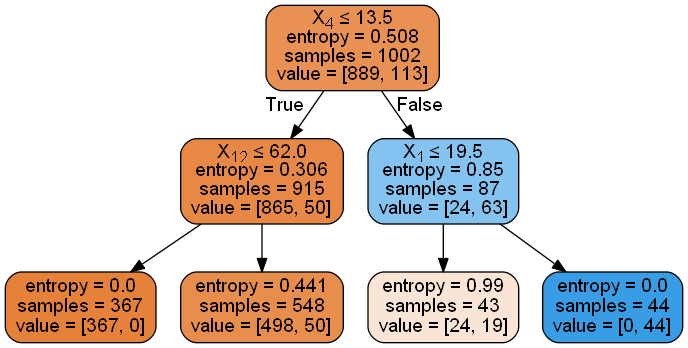

In [461]:
decision_tree(2)

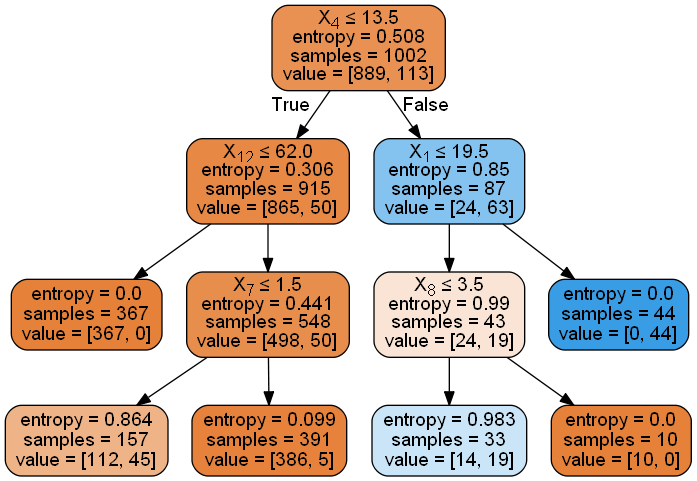

In [462]:
decision_tree(3)

In [463]:
malicious_model = sktree.DecisionTreeClassifier(max_depth=3, criterion='entropy')
malicious_model.fit(malicious_drop_train, malicious_train_New.Type)
malicious_drop_test = malicious_test_New.drop(["Type"], axis=1)
predicted_labels = malicious_model.predict(malicious_drop_test)
malicious_test_New['predicted_label_tree'] = predicted_labels
malicious_test_New.sample(5)

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,predicted_label_tree
233,38,8,2,5,0,25,3,2,2,330,3,5,306,330,3,0.0,0,0
146,44,9,1,27,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0
330,22,6,2,21,0,30,6,0,3,650,10,10,1417,950,10,4.0,0,0
106,39,7,1,11,10,29,9,0,1,865,11,12,19264,1045,11,2.0,0,0
305,38,8,2,2,0,73,13,13,9,1002,13,16,1012,1002,13,0.0,0,0


In [464]:
# Report the accuracy of model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(malicious_test_New.Type, predicted_labels)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 84.88%


#### Comment:
* First we use the Decision Tree with max depth 3 to have a test on our model. Tha accuracy is 84.88% in this case. Now we turn to use Random Forest to train this model again.

In [465]:
# Build both Random Forest and Naive Bayes classifiers to predict the TYPE variable
# Random Forest
rf_model = skens.RandomForestClassifier(n_estimators=10, oob_score=True, criterion='entropy')
rf_model.fit(malicious_drop_train, malicious_train_New.Type)
predicted_labels = rf_model.predict(malicious_drop_test)
malicious_test_New['predicted_rf_tree'] = predicted_labels
malicious_test_New.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,predicted_label_tree,predicted_rf_tree
0,78,15,0,0,0,0,8,6,6,672,8,9,562,672,8,0.0,0,0,0
1,39,8,1,1,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0
2,43,9,1,0,0,1,83,2,3,6008,87,107,147266,6312,87,4.0,0,0,0
3,52,10,0,2,1,2,0,0,0,0,0,0,0,0,0,0.0,0,0,0
4,100,20,2,2,2,3,1,0,1,66,1,3,190,66,1,0.0,1,0,1


In [466]:
accuracy = accuracy_score(malicious_test_New.Type, predicted_labels)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 88.37%


In [467]:
# check importance
rf_model.feature_importances_

array([0.04916885, 0.08198428, 0.02975754, 0.043951  , 0.2264408 ,
       0.05503751, 0.02580855, 0.09975837, 0.03442042, 0.04853092,
       0.0405489 , 0.07144677, 0.09004598, 0.05956698, 0.02973274,
       0.01380039])

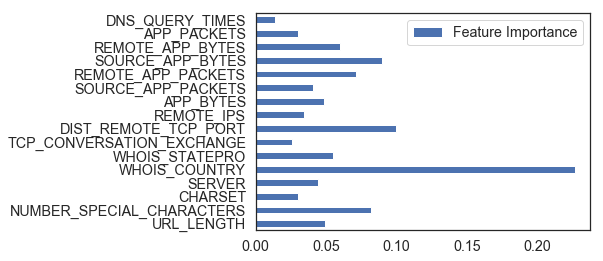

In [468]:
feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=malicious_drop_train.columns).plot(kind='barh')

#### Meaning of parameters in the Random Forest Model:
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

#### Comment:
* Before changing the number of "folds" and tuning hyperparameters, we set our number of trees in the forest to be 10 and build our model. The model accuracy is 88.37% and the feature importance plot has also been shown above. According to the result, the most important features contain "NUMBER_SPECIAL_CHARACTERS", "SOURCE_APP_PACKETS", "DIST_REMOTE_TCP_PORT" and "WHOIS_COUNTRY".

In [469]:
# Tune your Random Forest model by varying hyperparamters 
# Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 5, 7, 9],
             }
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(malicious_drop_train,malicious_train_New.Type)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [470]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [471]:
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 10}

In [472]:
# write a function to find the accuracy under different number of CV folds
def estimateUnderCV(cv_list):
    cv_accuracy = []
    cv_dic = []
    for cv_ in cv_list:
        grid_clf = GridSearchCV(rf_model, param_grid, cv=cv_)
        grid_clf.fit(malicious_drop_train,malicious_train_New.Type)
        dic = grid_clf.best_params_ # return the dic for parameters
        cv_dic.append(dic)
        # return the best model under this cv number
        rf_model_loop = skens.RandomForestClassifier(max_depth=dic['max_depth'],
                                                     n_estimators=dic['n_estimators'], oob_score=True, criterion='entropy')
        rf_model_loop.fit(malicious_drop_train, malicious_train_New.Type)
        predicted_labels = rf_model_loop.predict(malicious_drop_test)
        accuracy = accuracy_score(malicious_test_New.Type, predicted_labels)
        cv_accuracy.append(accuracy)
    return cv_dic, cv_accuracy

In [428]:
np.random.seed(0)
result = estimateUnderCV([5, 10, 15, 20, 25, 30, 50])
result

([{'max_depth': 9, 'n_estimators': 5},
  {'max_depth': 9, 'n_estimators': 5},
  {'max_depth': 9, 'n_estimators': 20},
  {'max_depth': 9, 'n_estimators': 20},
  {'max_depth': 7, 'n_estimators': 15},
  {'max_depth': 9, 'n_estimators': 10},
  {'max_depth': 9, 'n_estimators': 20}],
 [0.8953488372093024,
  0.9031007751937985,
  0.9612403100775194,
  0.9147286821705426,
  0.9263565891472868,
  0.9651162790697675,
  0.9224806201550387])

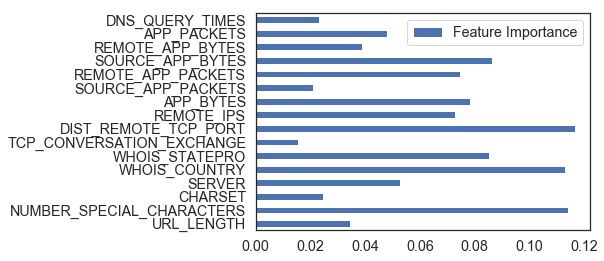

In [473]:
# Report the most important feature(s) based on your Random Forest classifier
rf_model = skens.RandomForestClassifier(max_depth=9, n_estimators=10, oob_score=True, criterion='entropy')
rf_model.fit(malicious_drop_train, malicious_train_New.Type)
feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=malicious_drop_train.columns).plot(kind='barh')

#### Comment for Random Forest:
* Here our "n_estimator" can be 5, 10, 15, 20 and 25 and "max_depth" can be 2, 5, 7 and 9.
* Initially, we fix our CV parameter to be 10 and build the random forest model. The corresponding estimated parameters are 7 and 25.
* Then we change our cv value into changable parameter and try to find the best estimation under each cv value. The result has been shown above. According to the result, when cv parameter is set to be 30, the corresponding estimated parameters are 9 and 10. Then accuracy can reach to 96.51%, which is the highest among all above cases.
* The feature importance plot (max_depth=9, n_estimator=10) has also been shown above. According to the result, the most important features contain "WHOIS_COUNTRY", "WHOIS_STATEPRO", "SOURCE_APP_BYTES", "NUMBER_SPECIAL_CHARACTERS" and "DIST_REMOTE_TCP_PORT".

In [474]:
# Experiment with setting the appropriate values for priors in the Naive Bayes model 
# (the priors should correspond to the proportions of the TYPE values)

# train the model -- Gaussian
def NaiveBayesPara(para_list):
    accuracy = {}
    high_acc = 0
    for para in para_list:
        gnb_model = sknb.GaussianNB(priors=[1-para, para])
        gnb_model.fit(malicious_drop_train, malicious_train_New.Type)
        y_pred = gnb_model.predict(malicious_drop_test)
        y_pred = y_pred.tolist()
        accuracy_ = accuracy_score(malicious_test_New.Type, y_pred)
        if accuracy_ > high_acc:
            high_acc = accuracy_
            high_para = para
        accuracy_ = str(accuracy_ * 100)
        accuracy[para] = accuracy_
    return high_acc, high_para, accuracy

In [475]:
np.random.seed(0)
para_gaussian = [0.01*i for i in range(100)]
para_gaussian.append(1)
acc_result, para_result, dic_result = NaiveBayesPara(para_gaussian)
print("corresponding prior parameters for Naive Bayes: [", 1-para_result, para_result, "]")
print("corresponding accuracy for Naive Bayes: ", acc_result)

corresponding prior parameters for Naive Bayes: [ 1.0 0.0 ]
corresponding accuracy for Naive Bayes:  0.8837209302325582


In [476]:
num = 0
for key in dic_result:
    if num < 10:
        print([key, dic_result[key]])
    num = num + 1

[0.0, '88.37209302325581']
[0.01, '29.069767441860467']
[0.02, '29.069767441860467']
[0.03, '28.294573643410853']
[0.04, '27.906976744186046']
[0.05, '27.906976744186046']
[0.06, '27.906976744186046']
[0.07, '27.906976744186046']
[0.08, '28.294573643410853']
[0.09, '28.294573643410853']


#### Comment for Naive Bayes Classifier:
* Here we use 100 groups of prior probabilities to find the most suitable parameters. The highest accuracy is 88.37% and it corresponding prior probability is (1.0 0.0), which indicates that all samples are assumed to be in group 0 here.

#### Summary for the comparison:
* According to the result, when cv parameter is set to be 30, max_depth to be 9 and n_estimator to be 10, the random forest model's accuracy can reach to 96.51%. For Naive Bayes method, if we assume that all samples are in one group, the highest accuracy is still less than 90%. It means that Naive Bayes method here doesn't work well for this data set. Then Random Forest model with certain parameters would be much better.

In [477]:
# find misclassfied error case in random forest method
malicious_test_New['error_rf'] = malicious_test_New['Type'] - malicious_test_New['predicted_rf_tree']
Counter(malicious_test_New['error_rf'])

Counter({0: 228, 1: 27, -1: 3})

In [478]:
# and include an in-depth explanation of how you might improve your results. 
# so you'll need to do some research about websites and internet protocols! 
error_filter = malicious_test_New[malicious_test_New['error_rf'] == 1]
not_error_filter = malicious_test_New[malicious_test_New['error_rf'] == 0]
error_filter.mean()

URL_LENGTH                     87.777778
NUMBER_SPECIAL_CHARACTERS      17.000000
CHARSET                         1.518519
SERVER                         12.185185
WHOIS_COUNTRY                   3.888889
WHOIS_STATEPRO                 21.740741
TCP_CONVERSATION_EXCHANGE       6.777778
DIST_REMOTE_TCP_PORT            0.000000
REMOTE_IPS                      0.814815
APP_BYTES                     738.370370
SOURCE_APP_PACKETS              8.037037
REMOTE_APP_PACKETS              9.777778
SOURCE_APP_BYTES             5980.074074
REMOTE_APP_BYTES              835.555556
APP_PACKETS                     8.037037
DNS_QUERY_TIMES                 1.259259
Type                            1.000000
predicted_label_tree            0.074074
predicted_rf_tree               0.000000
error_rf                        1.000000
dtype: float64

In [479]:
not_error_filter.mean()

URL_LENGTH                      55.096491
NUMBER_SPECIAL_CHARACTERS       10.592105
CHARSET                          1.543860
SERVER                          15.390351
WHOIS_COUNTRY                    1.714912
WHOIS_STATEPRO                  20.662281
TCP_CONVERSATION_EXCHANGE       20.315789
DIST_REMOTE_TCP_PORT             5.267544
REMOTE_IPS                       2.938596
APP_BYTES                     1959.289474
SOURCE_APP_PACKETS              22.201754
REMOTE_APP_PACKETS              23.074561
SOURCE_APP_BYTES             25440.903509
REMOTE_APP_BYTES              2102.947368
APP_PACKETS                     22.201754
DNS_QUERY_TIMES                  1.859649
Type                             0.013158
predicted_label_tree             0.048246
predicted_rf_tree                0.013158
error_rf                         0.000000
dtype: float64

#### Explanation for different variables:
* According to the data description, most of the common variables used to detect malicious websites have been included here.
* By using Feature Generator, we turn each URL into a feature vecotr with very high dimension.

* Most of the useful information in classification problem contains:
* URL_LENGTH: it is the number of characters in the URL.
* NUMBER_SPECIAL_CHARACTERS: it is number of special characters identified in the URL, such as, “/”, “%”, “#”, “&”, “. “, “=”.
* CHARSET: it is a categorical value and its meaning is the character encoding standard (also called character set).
* SERVER: it is a categorical value and its meaning is the operative system of the server got from the packet response.
* CONTENT_LENGTH: it represents the content size of the HTTP header.
* WHOIS_COUNTRY: it is a categorical variable, its values are the countries we got from the server response.
* WHOIS_STATEPRO: it is a categorical variable, its values are the states we got from the server response.
* TCP_CONVERSATION_EXCHANGE: This variable is the number of TCP packets exchanged between the server and our honeypot client.
* DIST_REMOTE_TCP_PORT: it is the number of the ports detected and different to TCP.
* REMOTE_IPS: this variable has the total number of IPs connected to the honeypot.
* APP_BYTES: this is the number of bytes transfered.
* SOURCE_APP_PACKETS: packets sent from the honeypot to the server.
* REMOTE_APP_PACKETS: packets received from the server.
* APP_PACKETS: this is the total number of IP packets generated during the communication between the honeypot and the server.
* DNS_QUERY_TIMES: this is the number of DNS packets generated during the communication between the honeypot and the server.
* The Final response is the "Type". Its values represent the type of web page analyzed, specifically, 1 is for malicious websites and 0 is for benign websites.

#### Comment:
* As we can see, many malicious websites are classified to be benign ones in these errors.
* Then we check the difference of attributes between normal samples and misclassified samples. According to the statistical output shown above, we found that there are some significant different attributes between these two groups.
* The table below show the difference:

|Attributes| Mean comparison (normal v.s mis)|
|----------|---------------------------------|
|"URL_LENGTH"|87-55|
|"NUMBER_SPECIAL_CHARACTERS"|17-10|
|"TCP_CONVERSATION_EXCHANGE"|6-20|
|"APP_BYTES"|738-1959|
|"SOURCE_APP_PACKETS" |8-22|
|"REMOTE_APP_PACKETS"|9-23|
|"SOURCE_APP_BYTES"|5980-25440|
|"REMOTE_APP_BYTES"|835-2102|
|"APP_PACKETS "|8-22|

* Generally speaking, URL of these malicious websites should have longer length and contain more special characters. Number of packets and bytes sent, received or transfered through these URL are smaller than the normal URL. Thus these two features can be taken as very important signs to tell whether the website is malicious or not.

#### Special Characters and URL Length Analysis:
* In order to deal with the special characters problem, we can divide a URL into two parts: the hostname and the path. As an example, with the URL www.geocities.com/usr/index.html, the hostname portion is www.geocities.com and the path portion is usr/index.html.
* Lexical features are the textual properties of the URL itself (not the content of the page it references). We may record the length of hostname, length of path and length of whole URL separately. Also, we can make a distinction between special characters belonging to the hostname, the path, the top-level domain (TLD) and primary domain name (the domain name given
to a registrar).

#### Number of Packets and Bytes Analysis:
* In order to deal with the packets and bytes problem, we may extract these relevant attributes information for each URL ahead of time. After introducing some indicator/binary variables, we can tell whether the number of packets and bytes for the URL is in valid range of benign websites or not and use indicator variables to mark. In this way, we can attach more importance to packets and bytes before the classification. Thus these relevant variables would make more contribution during the classification.

#### Finally:
* Based the analysis mentioned above, we would definitely introduce more variables to our previous data set. These variables like "Length of Hostname", "Length of Path", "Length of Whole", "Special characters in Hostname", "Special characters in Path" and indicator for valid packets & bytes range should be very helpful in telling the difference between malicious and benign websites. Thus the classification accuracy should be improved in this way.